In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
from tqdm import tqdm
import csv
import datetime
import pickle

import numpy as np
import jax

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

sys.path.append("..")
from axionmirror.snr import *
from axionmirror.spectral import *
from axionmirror.nfw import rho_NFW
from axionmirror.graveyard import *
from axionmirror.stats import bounded_sample

## 1. Download

In [ ]:
! wget "http://snrcat.physics.umanitoba.ca/SNRdownload.php?table=SNR" -O ../data/snr/SNRcat-SNR.csv
! wget "http://snrcat.physics.umanitoba.ca/SNRdownload.php?table=SNR" -O ../data/snr/SNRcat-OBS.csv

In [ ]:
# removed first 2 lines of the files
date_str = datetime.date.today().strftime("%Y%m%d")
for tag in ['SNR', 'OBS']:
    reader = csv.reader(open(f'../data/snr/SNRcat-{tag}.csv', 'r'), delimiter=';')
    next(reader); next(reader)
    writer = csv.writer(open(f'../data/snr/SNRcat{date_str}-{tag}_dehead.csv', 'w'), delimiter=';')
    writer.writerows(reader)

## 2. Filter valid SNR

### 2.1 Valid SNR from SNRcat

In [2]:
date_str = '20230426'

In [3]:
snr_list = []
n_d_t_valid = 0

with open(f'../data/snr/SNRcat{date_str}-SNR_dehead.csv', 'r') as csvf:
    csv_reader = csv.DictReader(csvf, delimiter=';')
    
    for i, row in enumerate(csv_reader):
        
        if row['G'] == 'G358.1+00.1':
            row['G'] = 'G358.1+01.0' # error in SNRcat
            
        snr = SNR(
            ID = row['G'],
            name_alt = row['id_alt'],
            snr_type = row['type'],
            l = float(row['G'][1:6]) * deg,
            b = float(row['G'][6:11]) * deg,
            size = float(row['size_coarse (arcmin)']) * arcmin,
            snrcat_dict = row
        )
        
        d_min = row['distance_min (kpc)'] # must have dist min & max
        d_max = row['distance_max (kpc)']
        t_now_min = row['age_min (yr)'] # must have age min & max
        t_now_max = row['age_max (yr)']
        
        snr.d_min = float(d_min) if d_min != '' else None
        snr.d_max = float(d_max) if d_max != '' else None
        snr.t_now_min = float(t_now_min) if t_now_min != '' else None
        snr.t_now_max = float(t_now_max) if t_now_max != '' else None
        
        if snr.d_min is not None and snr.d_max is not None:
            snr.d = np.sqrt(snr.d_min * snr.d_max)
        else:
            snr.d = None
            
        if snr.t_now_min is not None and snr.t_now_max is not None:
            snr.t_now = np.sqrt(snr.t_now_min * snr.t_now_max)
        else:
            snr.t_now = None
        
        snr_list.append(snr)
        
        if snr.d is not None and snr.t_now is not None:
            print('|', end='', flush=True)
            n_d_t_valid += 1
        else:
            print('.', end='', flush=True)
print(f'\nd t_now info valid = {n_d_t_valid}. total = {len(snr_list)}.')

|..|..|..............|...||.|...........|............||...|.....|..||.....|.|..|..|....|.||..|...|....|.|.||...|||.|...|.|.|.|||||..|.....|||...|..|..|||..|.|.||||..|..|...||.||||.||..||......|..|.||.

.|.|.|||....||..|.||..||...|....|.|||..||.||..|.....||.|.|...|...|......|....|..|....|....|...||.|....|....||.|...|...|||..|.||..........|....|||.|...|.......||...|..|....|......|.|..
d t_now info valid = 130. total = 383.


### 2.2 Valid SNR from Green's catalog
Requires SNR to have flux information. Copy [this page](https://www.mrao.cam.ac.uk/surveys/snrs/snrs.data.html) to `../data/snr/Green.txt`

In [4]:
for snr in snr_list:
    print(('.' if snr.Snu1GHz is None else '|'), end='')

...............................................................................................................................................................................................................................................................................................................................................................................................

In [5]:
varied_str = ''
cant_find_str = ''

with open('../data/snr/Green.txt') as f:
    lines = f.readlines()
    for i, line in enumerate(lines[4:]):
        line_strs = list(filter(None,line.split(' ')))
        green_dict = {}
        green_dict['ID'] = GID(line_strs[0], line_strs[1])
        green_dict['name_oth'] = '' if len(line_strs)<=11 else ' '.join(line_strs[11:]).replace('\n', '')
        green_dict['size_str'] = line_strs[7]
        green_dict['type'] = line_strs[8]
        green_dict['Snu1GHz'] = line_strs[9]
        green_dict['spec_ind'] = line_strs[10].replace('\n', '')
        
        snr = get_snr(green_dict['ID'], snr_list)
        snr.green_dict = green_dict
        
        Snu1GHz_str = green_dict['Snu1GHz'].replace('?','').replace('>','')
        if Snu1GHz_str != '':
            snr.Snu1GHz = float(Snu1GHz_str)
        
        si_str = green_dict['spec_ind'].replace('?','')
        if si_str != '':
            try:
                snr.si = float(si_str)
            except ValueError:
                snr.si = None
                varied_str += '\n'+green_dict['ID']+' '+green_dict['spec_ind']+' '+green_dict['name_oth']
        
    if cant_find_str == '':
        cant_find_str = 'None.'
    print('can\'t find: '+cant_find_str)
    print(varied_str)

can't find: None.

G000.9+00.1 varies 
G006.4-00.1 varies W28
G021.5-00.9 varies 
G027.8+00.6 varies 
G031.9+00.0 varies 3C391
G033.2-00.6 varies 
G065.7+01.2 varies DA 495
G069.0+02.7 varies CTB 80
G074.0-08.5 varies Cygnus Loop
G074.9+01.2 varies CTB 87
G180.0-01.7 varies S147
G263.9-03.3 varies Vela (XYZ)
G326.3-01.8 varies MSH 15-56
G354.1+00.1 varies 


In [6]:
for snr in snr_list:
    print(('.' if snr.Snu1GHz is None else '|'), end='')
print()
for snr in snr_list:
    print(('.' if snr.si is None else '|'), end='')

|.|||||||||||||.||||.||||.|||||||||.||||||||||||.||||||||||||||.|.|||||.|.|||.||..|||..|||..|||||||.|.|||.||.||.|||||||||.||.||||||||.|.|||||...|.|||.|||.||.|||..||||||.|..||||||||||.||......||..|.|.|||.|||..|...|||.||||..|.|..|.|.||.|||||||.|||||.|||.|||||||.|..|.|||...|||||.||.|..||.|..|....||||||||||..|||.|..|.|..||||.||||||||||.||.|..|.|||||..||||..||||||...|||||||||||.|.|||..
|.|.|.|||||||||.||||..|||.|||||||||.||||||||||||.||||||||||||||.|.|||||.|..||.||..|||..|..|.||||..|...|.|.||.||.||||..|||.||.||||||||...||||....|.|.|.|....|.|||||||||||.|..||||||||||.||......||..|.|.||.||||..|...|||.||.|..|.|..|...||.||||.||.||||....|.||..|||......||....||.|...|.|..|..|..|.......|.||.||..|||.|..|.|..|.||.||..|||||..||.|....|.|||...|||..||.|.|......||..||.....|.|..

### 2.3 Individual changes

In [7]:
snr = get_snr('G263.9-03.3', snr_list)
snr.name_alt = 'Vela'
snr.si = (2.47-1)/2 # fiducial: 2.47
snr.t_now = 12000 # fiducial: 10000-12000-14000
snr.d = 0.287 # kpc
snr.Snu1GHz = 670

snr = get_snr('G006.4-00.1', snr_list)
snr.name_alt = 'W28'
snr.si = 0.42 # Kassim 1992 | 330 MHz VLA OBSERVATIONS OF 20 GALACTIC SUPERNOVA REMNANTS
# density # https://arxiv.org/pdf/1805.03372.pdf, Reach et al 2005
snr.t_now = 34467 # yr
snr.d = 1.876 # kpc

snr = get_snr('G039.7-02.0', snr_list)
snr.name_alt = 'W50'
snr.t_now = 54772 # fiducial: 30000-54772-100000
snr.d = 4.77 # kpc
snr.si = 0.7 # fiducial: 0.7

snr = get_snr('G326.3-01.8', snr_list)
snr.name_alt = 'MSH 15-56'
snr.si = 0.34 # RADIO EMISSION FROM THE COMPOSITE SUPERNOVA REMNANT G326.3-1.8 (MSH 15-56)

In [8]:
# set t_free for size calculation
for snr in snr_list:
    snr.t_free = 100 # [yr]

In [9]:
dump_snr_list(snr_list, "../outputs/snr/prebuild_snr_list.json")

## 3. Full info list and partial info list

In [3]:
snr_list = load_snr_list("../outputs/snr/prebuild_snr_list.json")

In [4]:
snr_list_fullinfo = []
snr_list_partialinfo = []

for snr in snr_list:
    v = np.array([snr.d, snr.t_now, snr.Snu1GHz, snr.si])
    if np.all(v != None):
        snr_list_fullinfo.append(snr)
    else:
        snr_list_partialinfo.append(snr)

dump_snr_list(snr_list_fullinfo, "../outputs/snr/prebuild_snr_list_fullinfo.json")
dump_snr_list(snr_list_partialinfo, "../outputs/snr/prebuild_snr_list_partialinfo.json")
print(f'full info: {len(snr_list_fullinfo)}. partial info: {len(snr_list_partialinfo)}.')

full info: 94. partial info: 289.


### 3.1 Build fullinfo list

In [8]:
# build without lightcurve
snr_list_fullinfo = load_snr_list("../outputs/snr/prebuild_snr_list_fullinfo.json")
for snr in tqdm(snr_list_fullinfo):
    snr.t_MFA = 100 # [yr]
    snr.t_free = 100 # [yr]
    snr.build(rho_DM=rho_NFW, tiop='2', use_lightcurve=False, infer_lightcurve_from_now=None, integrate_method='trapz')
dump_snr_list(snr_list_fullinfo, f"../outputs/snr/snr-fullinfo-nolightcurve.json")

100%|██████████| 94/94 [00:00<00:00, 286.17it/s]


In [9]:
n_samples = 300 # repeat to have a 'sample'
os.makedirs(f"../outputs/snr/fullinfo_samples_nofree", exist_ok=True)
for i_sample in tqdm(range(n_samples)):
    dump_snr_list(snr_list_fullinfo, f"../outputs/snr/fullinfo_samples_nofree/fullinfo_{i_sample}.json")

100%|██████████| 300/300 [00:07<00:00, 40.63it/s]


In [15]:
# build with lightcurve t_pk sampled L_pk inferred
for i_sample in tqdm(range(100)):
    
    snr_list_fullinfo = load_snr_list("../outputs/snr/prebuild_snr_list_fullinfo.json")
    for snr in snr_list_fullinfo:
        snr.t_pk = sample_t_pk(1).item()
        snr.t_free = 300 # [yr]
        snr.build(rho_DM=rho_NFW, tiop='2', use_lightcurve=True, infer_lightcurve_from_now=True, integrate_method='trapz')
    dump_snr_list(snr_list_fullinfo, f"../outputs/snr/fullinfo_samples/fullinfo_{i_sample}.json")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


In [4]:
# build with lightcurve t_pk L_pk jointly sampled
var_flag = 'tf300' # {'base', 'ti1', 'tf30', 'tf300'} variation flags
var_name = f'fullinfo_samples_{var_flag}'
n_samples = 300

if var_flag == 'ti1':
    tiop = '1'
else:
    tiop = '2'

if var_flag == 'tf30':
    t_free = 30 # [yr]
elif var_flag == 'tf300':
    t_free = 300 # [yr]
else:
    t_free = 100 # [yr]

os.makedirs(f"../outputs/snr/{var_name}", exist_ok=True)
for i_sample in tqdm(range(n_samples)):
    
    snr_list_fullinfo = load_snr_list("../outputs/snr/prebuild_snr_list_fullinfo.json")
    for snr in snr_list_fullinfo:
        snr.t_free = t_free
        snr.t_pk = sample_t_pk_L_pk(snr, tiop=tiop, num_samples=1).item()
        snr.build(rho_DM=rho_NFW, tiop=tiop, use_lightcurve=True, infer_lightcurve_from_now=True, integrate_method='trapz')
    dump_snr_list(snr_list_fullinfo, f"../outputs/snr/{var_name}/fullinfo_{i_sample}.json")

100%|██████████| 300/300 [01:57<00:00,  2.54it/s]


### 3.2 Sample and build partialinfo list

In [2]:
# build with no lightcurve
var_flag = 'nofree'
var_name = f'partialinfo_samples_{var_flag}'
n_samples = 300

tiop = '2'
t_free = 100 # [yr]
t_MFA = 100 # [yr]

rng_key = jax.random.PRNGKey(42)

kernel, z_scale = pickle.load(open("../outputs/snr/snr_fi_kde_zscale.p", 'rb'))
snr_fi_pdf_stz = lambda stz: snr_fi_pdf(stz, kernel, z_scale)

for i_sample in tqdm(range(n_samples)):
    
    snr_list_partialinfo = load_snr_list("../outputs/snr/prebuild_snr_list_partialinfo.json")
    snr_list_partialinfo_include = []
    for snr in snr_list_partialinfo:
        if snr.d is None:
            rng_key, key = jax.random.split(rng_key)
            snr.d = sample_snr_d(key, snr_fi_pdf_stz, snr.l, snr.b, 0., 30.).item() # [kpc]

        if snr.t_now is None:
            t_now_sampler = lambda: sample_t_now(1).item()
            snr.t_now = bounded_sample(t_now_sampler, snr.t_now_min, snr.t_now_max)

        if snr.size == 0:
            snr.size = sample_size_now(1, t_now=snr.t_now).item()

        if snr.si is None or isinstance(snr.si, str):
            snr.si = sample_si(1).item()

        # Snu1GHz
        snr.t_free = t_free
        snr.t_MFA = t_MFA
        if snr.Snu1GHz is None:
            continue
            
        snr.build(integrate_method='trapz', tiop=tiop, use_lightcurve=False, infer_lightcurve_from_now=None)
        snr_list_partialinfo_include.append(snr)
    
    os.makedirs(f"../outputs/snr/{var_name}", exist_ok=True)
    dump_snr_list(snr_list_partialinfo_include, f"../outputs/snr/{var_name}/partialinfo_{i_sample}.json")

100%|██████████| 300/300 [03:58<00:00,  1.26it/s]


In [ ]:
var_flag = 'tf300' # {'base', 'ti1', 'tf30', 'tf300'} variation flags
var_name = f'partialinfo_samples_{var_flag}'
n_samples = 300

if var_flag == 'ti1':
    tiop = '1'
else:
    tiop = '2'

if var_flag == 'tf30':
    t_free = 30 # [yr]
elif var_flag == 'tf300':
    t_free = 300 # [yr]
else:
    t_free = 100 # [yr]

rng_key = jax.random.PRNGKey(42)

kernel, z_scale = pickle.load(open("../outputs/snr/snr_fi_kde_zscale.p", 'rb'))
snr_fi_pdf_stz = lambda stz: snr_fi_pdf(stz, kernel, z_scale)

for i_sample in tqdm(range(n_samples)):
    
    snr_list_partialinfo = load_snr_list("../outputs/snr/prebuild_snr_list_partialinfo.json")
    for snr in snr_list_partialinfo:
        if snr.d is None:
            rng_key, key = jax.random.split(rng_key)
            snr.d = sample_snr_d(key, snr_fi_pdf_stz, snr.l, snr.b, 0., 30.).item() # [kpc]

        if snr.t_now is None:
            t_now_sampler = lambda: sample_t_now(1).item()
            snr.t_now = bounded_sample(t_now_sampler, snr.t_now_min, snr.t_now_max)

        if snr.size == 0:
            snr.size = sample_size_now(1, t_now=snr.t_now).item()

        if snr.si is None or isinstance(snr.si, str):
            snr.si = sample_si(1).item()

        # Snu1GHz
        snr.t_free = t_free
        if snr.Snu1GHz is not None:
            infer_lightcurve_from_now = True
            snr.t_pk = sample_t_pk_L_pk(snr, tiop=tiop, num_samples=1).item()
        else:
            infer_lightcurve_from_now = False
            snr.Snu1GHz_pk = sample_Snu1GHz_pk(1, d=snr.d, si=snr.si).item()
            snr.t_pk = sample_t_pk(1).item()
            
        snr.build(integrate_method='trapz', tiop=tiop, use_lightcurve=True, infer_lightcurve_from_now=infer_lightcurve_from_now)
    
    os.makedirs(f"../outputs/snr/{var_name}", exist_ok=True)
    dump_snr_list(snr_list_partialinfo, f"../outputs/snr/{var_name}/partialinfo_{i_sample}.json")

100%|██████████| 300/300 [06:39<00:00,  1.33s/it]


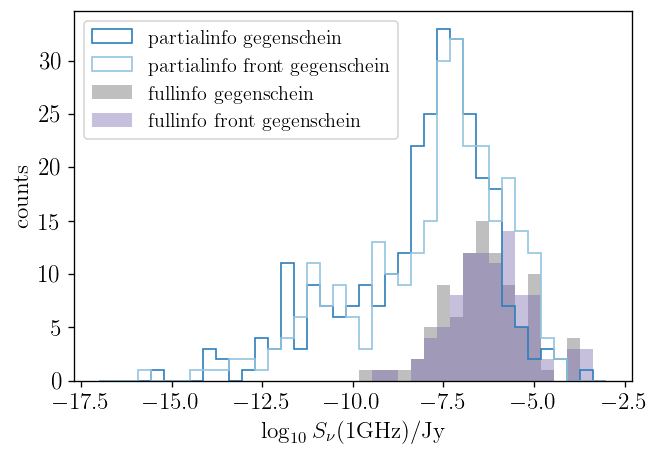

In [3]:
fig, ax = plt.subplots()

bins = np.linspace(-17, -3, 40)

for i in range(1):
    snr_list_fullinfo = load_snr_list(f"../outputs/snr/fullinfo_samples_base/fullinfo_{i}.json")
    snr_list_partialinfo = load_snr_list(f"../outputs/snr/partialinfo_samples_base/partialinfo_{i}.json")
    ax.hist(np.log10([snr.Sgnu(1000) for snr in snr_list_partialinfo]), bins=bins, histtype='step', color=cms['Blues'](0.7), alpha=1, label=('partialinfo gegenschein' if i==0 else None))
    ax.hist(np.log10([snr.Sfgnu(1000) for snr in snr_list_partialinfo]), bins=bins, histtype='step', color=cms['Blues'](0.4), alpha=1, label=('partialinfo front gegenschein' if i==0 else None))
    ax.hist(np.log10([snr.Sgnu(1000) for snr in snr_list_fullinfo]), bins=bins, histtype='bar', color=cms['Greys'](0.7), alpha=0.4, label=('fullinfo gegenschein' if i==0 else None))
    ax.hist(np.log10([snr.Sfgnu(1000) for snr in snr_list_fullinfo]), bins=bins, histtype='bar', color=cms['Purples'](0.7), alpha=0.4, label=('fullinfo front gegenschein' if i==0 else None))

ax.set(xlabel=r'$\log_{10}S_\nu(\mathrm{1GHz})/\mathrm{Jy}$', ylabel='counts')
ax.legend(loc='upper left');

Previous
- Different partialinfo sampling.
- fullinfo without sampling: $t_\mathrm{peak}$ taken to be 50 days.

![](../outputs/fullinfo_wo_sample_tpk.png)

## Check

In [10]:
a = pickle.load(open(f'../data/snr/snrlist_none.p', 'rb'))
b = load_snr_list("../data/snr/snrlist_none.json")

In [ ]:
for sa, sb in zip(a, b):
    print((sa.image_sigma_fg- sb.image_sigma_fg)/sa.image_sigma_fg)

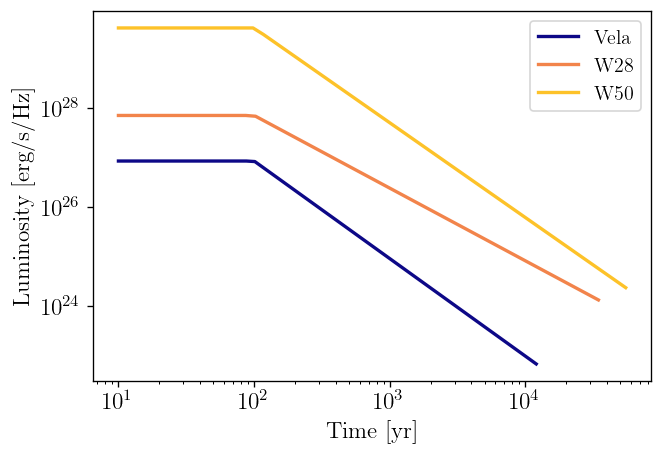

In [13]:
# plot Vela, W28 W50
fig, ax = plt.subplots()

colors = [ plt.get_cmap('plasma')(x) for x in [0.0, 0.7, 0.87] ]

for i, name in enumerate(['Vela', 'W28', 'W50']):
    snr = get_snr(name, snr_list_fullinfo)
    t_s = np.logspace(np.log10(10), np.log10(snr.t_now), 50) # [yr]
    L_s = [4*np.pi * (snr.d*kpc)**2 * 1e-23 * snr.Snu_t_fl(1000, t) for t in t_s]
    ax.plot(t_s, L_s, label=name, color=colors[i], lw=2)
ax.set(xscale='log', yscale='log')
ax.set(xlabel='Time [yr]', ylabel='Luminosity [erg/s/Hz]')
ax.legend();

In [ ]:
# expected gegenschein flux
get_snr('Vela', snr_list_fullinfo).Sgnu(1000)